In [17]:
# Import required libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [18]:
def is_black_red_blue(hsv_color):
    """
    Check if given HSV mean color belongs to black, red, or blue range.
    hsv_color is from cv2.mean in (h, s, v, _) format where:
    h: [0,180], s: [0,255], v: [0,255]
    """
    h, s, v, _ = hsv_color
    
    # Black: strict brightness requirement
    if v < 25:
        return True
    
    # Red: narrow range near 0 or 180
    if (0 <= h <= 5) or (h >= 175):
        return True
    
    # Blue: narrow Hue range for distinct blue
    if 105 <= h <= 125:
        return True
    
    return False

In [19]:
def process_frame(frame):
    """
    Process single frame to detect objects
    """
    # Convert PIL image to cv2 format if needed
    if isinstance(frame, Image.Image):
        frame = np.array(frame)
    
    # Convert RGB to BGR if from PIL
    if frame.shape[-1] == 3:  # If RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    # Resize frame to 50x50
    frame = cv2.resize(frame, (50, 50))
    
    # Gaussian blur for background approximation
    blurred = cv2.GaussianBlur(frame, (3, 3), 0)
    
    # Get absolute difference
    diff = cv2.absdiff(frame, blurred)
    
    # Convert to grayscale
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
    # Threshold difference image
    _, thresh_diff = cv2.threshold(gray_diff, 2, 255, cv2.THRESH_BINARY)
    
    # Morphological operations
    kernel = np.ones((3,3), np.uint8)
    thresh_diff = cv2.morphologyEx(thresh_diff, cv2.MORPH_OPEN, kernel)
    thresh_diff = cv2.morphologyEx(thresh_diff, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(thresh_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    marked_frame = frame.copy()
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 2 and area < 200:
            # Create mask for mean color calculation
            mask = np.zeros((50,50), dtype=np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            
            # Calculate mean HSV value
            mean_hsv = cv2.mean(hsv, mask=mask)
            
            # Skip if black/red/blue
            if is_black_red_blue(mean_hsv):
                continue
            
            # Draw bounding box
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.array(box, dtype=np.int32)
            cv2.drawContours(marked_frame, [box], 0, (255, 255, 255), 1)
            
            # Draw center point
            center = np.mean(box, axis=0).astype(np.int32)
            cv2.circle(marked_frame, tuple(center), 1, (255, 255, 255), -1)
    
    return frame, marked_frame, diff, thresh_diff

In [20]:
def process_and_visualize_gif(gif_path, max_frames=20):
    """
    Process GIF and show all frames
    """
    gif = Image.open(gif_path)
    frames = []
    frame_count = 0
    
    # First collect all frames
    while True:
        try:
            gif.seek(frame_count)
            frame = gif.convert('RGB')
            
            # Process frame
            original_frame, marked_frame, diff, thresh_diff = process_frame(frame)
            frames.append((original_frame, marked_frame, diff, thresh_diff))
            
            frame_count += 1
            if frame_count >= max_frames:
                break
                
        except EOFError:
            break
    
    # Then display all frames in a grid
    num_frames = len(frames)
    num_cols = 4  # 4 images per frame
    num_rows = num_frames
    
    plt.figure(figsize=(20, 5*num_frames))
    
    for i, (original, marked, diff, thresh) in enumerate(frames):
        # Original frame
        plt.subplot(num_rows, num_cols, i*num_cols + 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Frame {i}')
        plt.axis('off')
        
        # Difference image
        plt.subplot(num_rows, num_cols, i*num_cols + 2)
        plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
        plt.title(f'Difference {i}')
        plt.axis('off')
        
        # Threshold image
        plt.subplot(num_rows, num_cols, i*num_cols + 3)
        plt.imshow(thresh, cmap='gray')
        plt.title(f'Threshold {i}')
        plt.axis('off')
        
        # Marked frame
        plt.subplot(num_rows, num_cols, i*num_cols + 4)
        plt.imshow(cv2.cvtColor(marked, cv2.COLOR_BGR2RGB))
        plt.title(f'Detected Objects {i}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Processed {num_frames} frames")

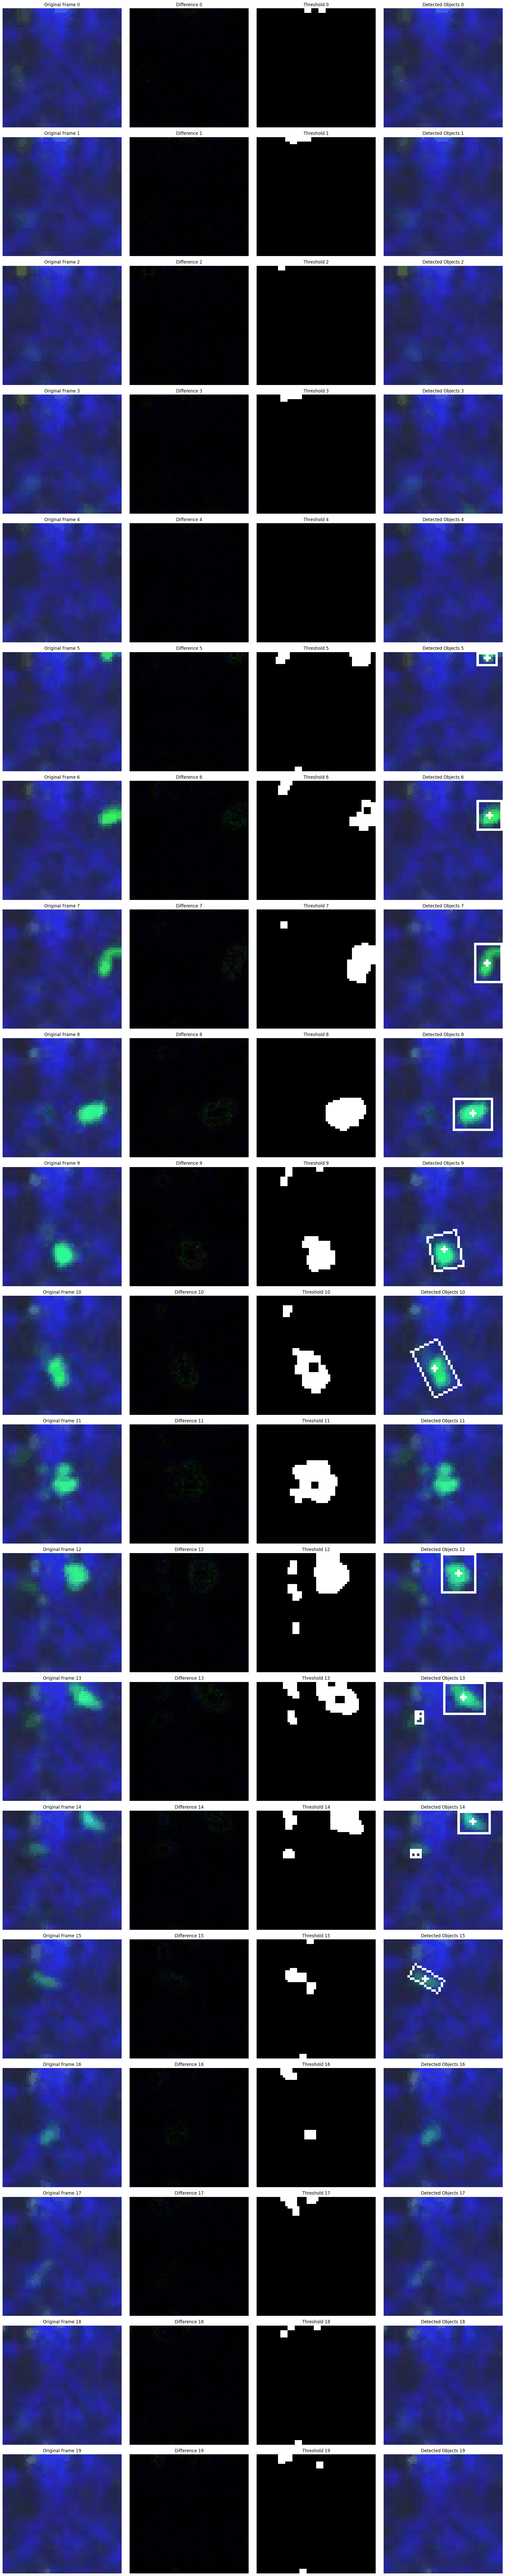

Processed 20 frames


In [21]:
# Test on a single GIF
input_gif = "data/test_phase2_gifs/05/05_2.gif"  # Replace with actual path
process_and_visualize_gif(input_gif)